# <h1 align="center"><font color="red">LLM prompt uncertainty test</font></h1>

<font color="yellow">Senior Data Scientist.: Dr. Eddy Giusepe Chirinos Isidro</font>

Este Notebook foi baseado no Tutorial de [Armin Catovic]().

In [1]:
import json
from matplotlib import pyplot as plt # import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
import os
from scipy.stats import gaussian_kde
from typing import Optional, Tuple

In [2]:
import openai
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
#openai.api_key  = os.environ['OPENAI_API_KEY']
Eddy_key_openai  = os.environ['OPENAI_API_KEY']

from openai import OpenAI
client = OpenAI(api_key=Eddy_key_openai)

In [3]:
def get_linprob(logprob: float) -> float:
    return np.round(np.exp(logprob) * 100.0, 2)


In [4]:

print(get_linprob(-0.00011129))

99.99


In [5]:
def run(user_prompt: str, system_prompt: Optional[str] = None) -> Tuple[float, float]:
    if system_prompt is None:
        system_prompt = "Retorna saída JSON onde a resposta é especificada como um único valor numérico no campo `answer`."
    
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        response_format={"type": "json_object"},
        logprobs=True,
        top_logprobs=2, # An integer between 0 and 20 specifying the number of most likely tokens to return at each token position, each with an associated log probability. logprobs must be set to true if this parameter is used.
        temperature=0.0,
    )

    answer = json.loads(completion.choices[0].message.content)["answer"]
    logprob = completion.choices[0].logprobs.content[8].logprob
    linprob = get_linprob(logprob)

    return (answer, linprob)

<font color="gree">OBS:</font>

`response_format`
An object specifying the format that the model must output. Compatible with `GPT-4 Turbo` and all GPT-3.5 Turbo models newer than gpt-3.5-turbo-1106.

Setting to `{"type": "json_object"}` enables `JSON` mode, which guarantees the message the model generates is valid JSON.

`Important:` when using JSON mode, you must also instruct the model to produce JSON yourself via a system or user message. Without this, the model may generate an unending stream of whitespace until the generation reaches the token limit, resulting in a long-running and seemingly "stuck" request. Also note that the message content may be partially cut off if finish_reason="length", which indicates the generation exceeded max_tokens or the conversation exceeded the max context length.

In [6]:
answer, linprob = run(user_prompt="9.11 ou 9.9 - qual é maior?")

print(answer, linprob)

9.9 81.75


In [7]:
num_trials = 100 #1_000
correct_answer = 9.9

In [8]:
def run_experiment(num_trials: int, correct_answer: float, user_prompt: str, system_prompt: Optional[str] = None) -> None:
    trial_results = []
    trial_linprobs = []

    for ix in range(num_trials):
        answer, linprob = run(
            user_prompt=user_prompt,
            system_prompt=system_prompt,
        )
        trial_results.append(answer == correct_answer)
        trial_linprobs.append(linprob)

    p_correct = np.round(sum(trial_results) / len(trial_results) * 100.0, 2)

    print("<USER_PROMPT>:", user_prompt)
    print("<SYSTEM_PROMPT>:", system_prompt)
    print("P(CORRECT) = ", p_correct)

    kde = gaussian_kde(trial_linprobs)
    dist_space = np.linspace(min(trial_linprobs), max(trial_linprobs), 100)
    plt.plot(dist_space, kde(dist_space))
    plt.show()
    

<USER_PROMPT>: 9.11 ou 9.9 - qual é maior?
<SYSTEM_PROMPT>: None
P(CORRECT) =  100.0


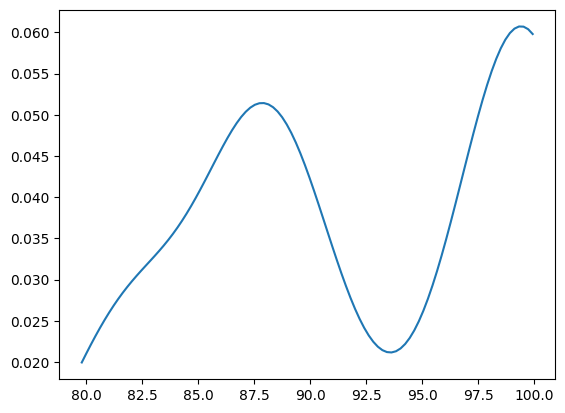

In [9]:
user_prompt = "9.11 ou 9.9 - qual é maior?"

run_experiment(num_trials, correct_answer, user_prompt)

<USER_PROMPT>: Qual é maior, 9.11 ou 9.9?
<SYSTEM_PROMPT>: None
P(CORRECT) =  100.0


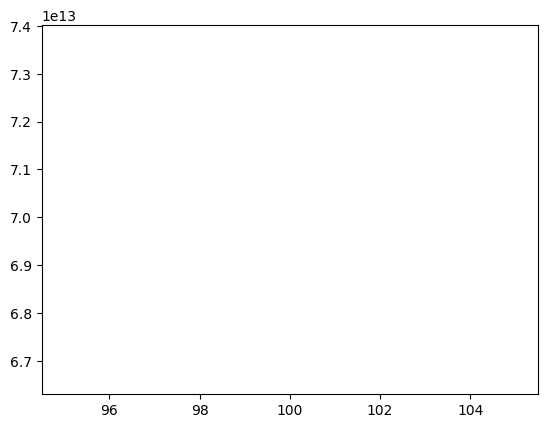

In [10]:
user_prompt = "Qual é maior, 9.11 ou 9.9?"

run_experiment(num_trials, correct_answer, user_prompt)

In [ ]:
user_prompt = "Qual é maior, 9.11 ou 9.9? Forneça o raciocínio sobre como você obteve a resposta no campo `raciocínio`."

run_experiment(num_trials, correct_answer, user_prompt)

In [ ]:
user_prompt = "Qual é maior, 9.11 ou 9.9?"
system_prompt = """
Retorna saída JSON onde a resposta é especificada como um único valor numérico no campo `answer`.
Forneça o raciocínio sobre como você obteve a resposta no campo `reasoning`.
"""

run_experiment(num_trials, correct_answer, user_prompt, system_prompt)